__<center>Computational Finance</center>__

__Individual assignement__
- Omar Jarir 

In [1]:
# Importing the necessary libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta
import re

# Setting the print options.
pd.set_option("display.precision", 4)

In [2]:
# Importing the file containing the market data for bond yields.
from ha_cf_2021 import *

__a) Build a pandas DataFrame with the data using the dates as columns and year
fractions of the tenors as index__

In [3]:
# The matrix data need to be inversed in order to create the dataframe

MarketData = pd.DataFrame(data=np.array(data).T, index = tenors, columns=dates)
MarketData.head()

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
3M,-0.545,-0.504,-0.502,-0.462,-0.455
6M,-0.529,-0.499,-0.491,-0.459,-0.446
1Y,-0.523,-0.499,-0.476,-0.447,-0.421
2Y,-0.604,-0.561,-0.462,-0.485,-0.352
3Y,-0.471,-0.386,-0.328,-0.350,-0.235


__b) Plot the yield curve for each date.__

In [4]:
# Function used in order to get the year fraction of each tenor.

def YearFraction(tenor):
    yf = float(re.findall('\d+\.?\d*', tenor)[0])
    if 'M' in tenor:
        return yf/12.0
    if 'Y' in tenor:
        return yf

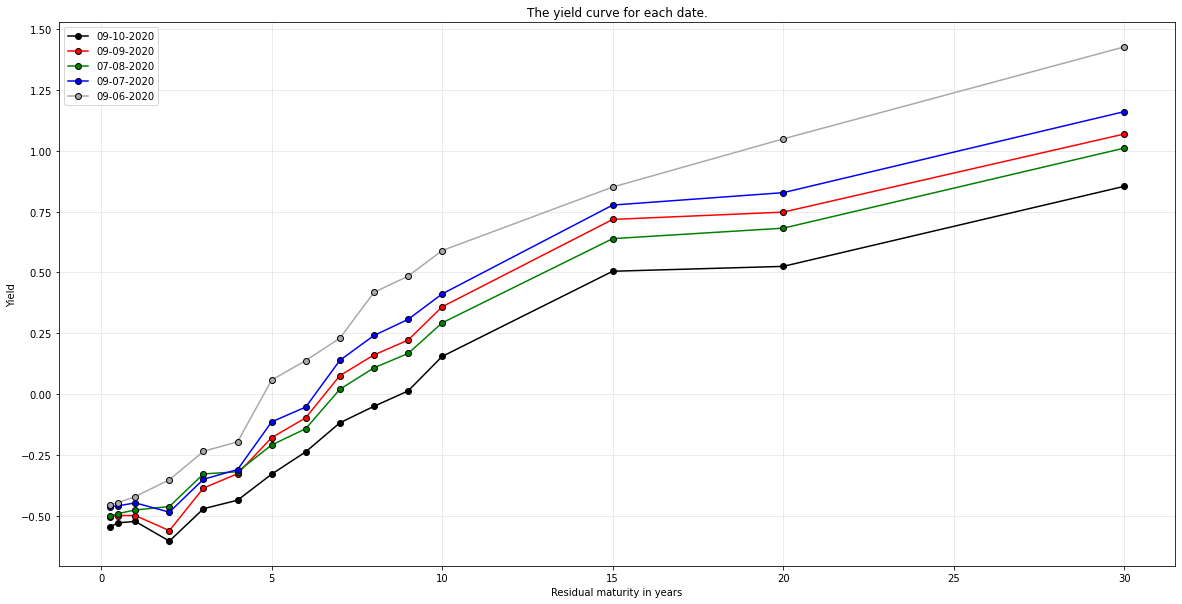

In [5]:
# Ploting the Yield curve for each date.
Colors = ['black', 'red', 'green', 'blue', 'darkgrey']

fig, ax = plt.subplots(figsize=(20,10))
MarketData.set_index(MarketData.index.map(YearFraction)).plot(ax=ax, color= Colors, marker='o', mec='black',
                                              title = "The yield curve for each date.")
ax.set_xlabel('Residual maturity in years')
ax.grid(alpha=0.3)
ax.set_ylabel('Yield')
ax.legend()
plt.show();

__c) Estimate the NSS parameters for each date.__

In [6]:
# The Nelson Siegel Svensson model.

def Nss(p, term):
    beta0, beta1, beta2, beta3, tau1, tau2 = p
    return (beta0
            +beta1*(1-np.exp(-term/tau1))/(term/tau1)
            +beta2*((1-np.exp(-term/tau1))/(term/tau1)-np.exp(-term/tau1))
            +beta3*((1-np.exp(-term/tau2))/(term/tau2)-np.exp(-term/tau2)))

In [7]:
# Function to calculate the errors, it is the one to be minimized.

def Error(p, x, y): return ((Nss(p, x) - y)**2).sum()

In [8]:
# The vector x containing the year fraction of each tenor, it will be used to minimize the error.
x = MarketData.index.map(YearFraction).values

# An Initional guess of the NSS parameters. 
p0 = np.array([ 1, 1, 1, 1, 1,  1]) 

# Creating a dataframe with the NSS parameters for each date.
Params = pd.DataFrame(columns = MarketData.columns, index = ['beta0', 'beta1', 'beta2', 'beta3', 'tau1', 'tau2'])

# Looping over each column in the dataframe MarketData.
for col in MarketData.columns:
    Params[col] = minimize(Error, p0, args=(x, MarketData[col].values))['x']

# Showing the results.
Params

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
beta0,1.1931e+00,1.3983,1.3599,1.4709e+00,17.6857
beta1,-1.7100e+00,-1.8583,-1.8774,-1.9248e+00,-18.1227
beta2,-8.8126e-06,-0.0014,0.8406,-1.5360e-05,-10.2080
beta3,-3.8017e+00,-3.7023,-4.2137,-4.3963e+00,-42.2011
tau1,1.1902e+00,1.3872,1.4510,9.1521e-01,4.2014
tau2,2.4693e+00,2.3120,2.4214,2.0953e+00,21.4523


__d) Plot the NSS Yield curve for each date__

- Method 1:

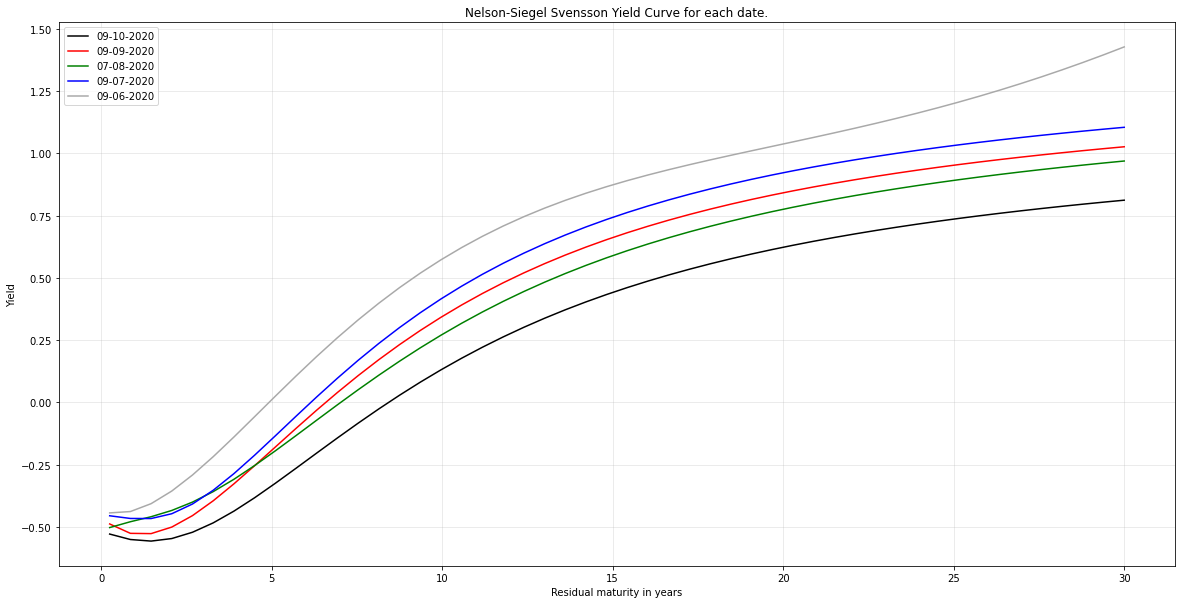

In [9]:
# Uising the numpy function linspace we plot the NSS Yield curve for each date.
zz = np.linspace(0.25,30)

fig, ax = plt.subplots(figsize=(20,10)) 
for idx, col in enumerate(Params):
    plt.plot(zz, Nss(Params[col].values, zz), label = col, color = Colors[idx])
    
plt.legend()
plt.grid(alpha=0.3)
plt.xlabel("Residual maturity in years")
plt.ylabel("Yield")
plt.title('Nelson-Siegel Svensson Yield Curve for each date.')
plt.show();

- Method 2:

In [10]:
# Adding a new column to each dataframe containing The NSS Yield Curve for each date.

for idx, col in enumerate(MarketData):
    MarketData['NSS_'+str(Params.shape[1] - idx)] = Nss(Params[col].values, MarketData.index.map(YearFraction).values) 

In [11]:
MarketData.tail()

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020,NSS_5,NSS_4,NSS_3,NSS_2,NSS_1
9Y,0.013,0.222,0.167,0.307,0.485,0.0505,0.2558,0.1878,0.3256,0.4855
10Y,0.155,0.359,0.293,0.412,0.590,0.1334,0.3448,0.2727,0.4186,0.5757
15Y,0.505,0.718,0.639,0.777,0.851,0.4417,0.6621,0.5894,0.7433,0.8740
20Y,0.525,0.748,0.682,0.828,1.049,0.6232,0.8420,0.7758,0.9226,1.0381
30Y,0.854,1.069,1.011,1.161,1.427,0.8123,1.0269,0.9697,1.1052,1.4282


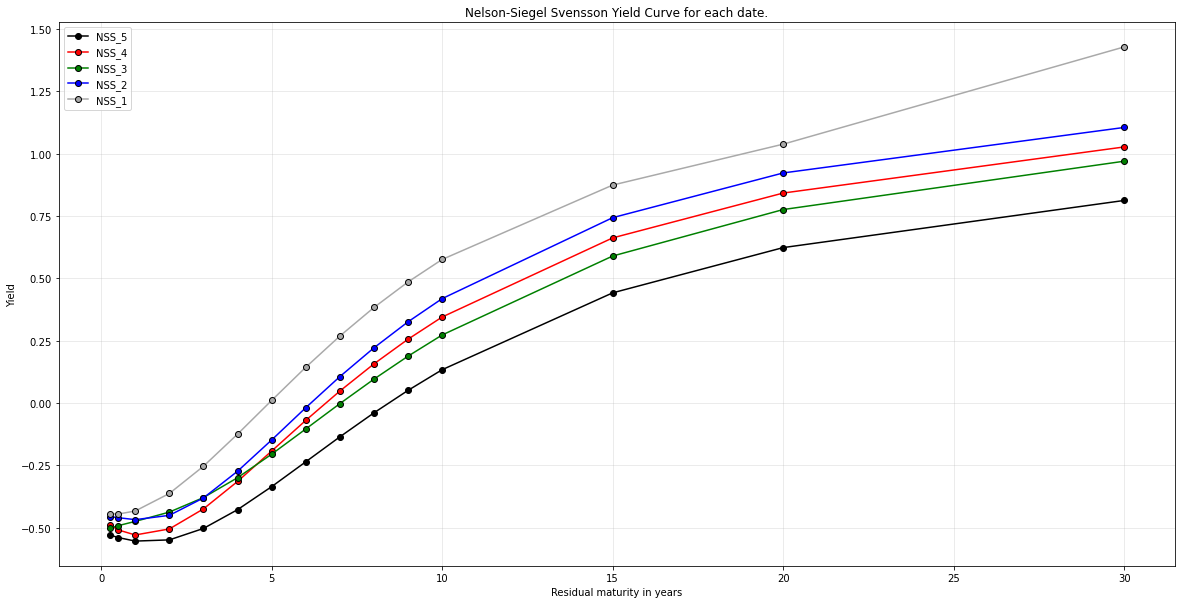

In [12]:
# Ploting The NSS Yield Curve for each date.

fig, ax = plt.subplots(figsize=(20,10)) 
for idx, col in enumerate(Params):
    MarketData.set_index(MarketData.index.map(YearFraction))[f'NSS_{Params.shape[1] - idx}'].plot(ax=ax, color=Colors[idx], \
                                    marker='o', mec='black', \
                                    title=f'Nelson-Siegel Svensson Yield Curve for each date.')
    ax.set_xlabel('Residual maturity in years')
    ax.grid(alpha=0.3)
    ax.set_ylabel('Yield')
    ax.legend()
plt.show()

__e) Plot the evolution of the 9M, 3.5Y, 12.5Y and the 25Y rate over the curve dates (a line for each tenor)__

In [13]:
# Using the NSS model to find the values 9M, 3.5Y, 12.5Y and the 25Y rate.

xx = [YearFraction(_) for _ in ['9M', '3.5Y', '12.5Y', '25Y']]

# Creating a dataframe to contain the new values for each date.

NewTenors = pd.DataFrame(index = ['9M', '3.5Y', '12.5Y', '25Y'], columns = MarketData.iloc[:,0:5].columns)

# Looping over the dataframe and using the Nss function to find the corresponding rates.

for idxc, col in enumerate(Params):
    for idxr, _ in enumerate(xx):
        NewTenors.iloc[idxr, idxc] = Nss(Params[col], xx[idxr])  
        
NewTenors

,09-10-2020,09-09-2020,07-08-2020,09-07-2020,09-06-2020
9M,-0.5483,-0.5226,-0.4832,-0.4649,-0.4418
3.5Y,-0.4686,-0.3723,-0.342,-0.3308,-0.1909
12.5Y,0.308,0.5268,0.452,0.6062,0.7522
25Y,0.7363,0.9528,0.8918,1.032,1.2009


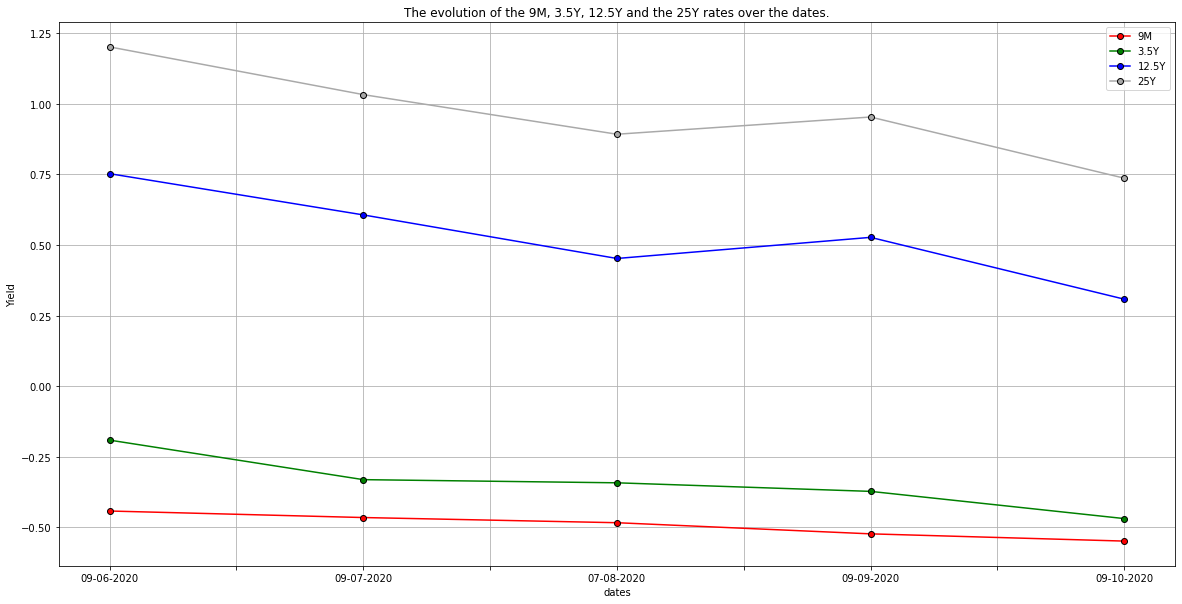

In [14]:
# Ploting the evolution of the 9M, 3.5Y, 12.5Y and the 25Y rate over the curve dates (a line for each tenor).

NewTenors.T.iloc[::-1].plot(title='The evolution of the 9M, 3.5Y, 12.5Y and the 25Y rates over the dates.', \
                            xlabel='dates', ylabel='Yield', \
                            marker='o', mec='black',\
                            figsize=(20,10), color = Colors[1:], grid = True) 
plt.show()

__f) Plot the market data points vs the NSS fit for each date using 5 subplots sharing the y axis (One market date in each subplot)__

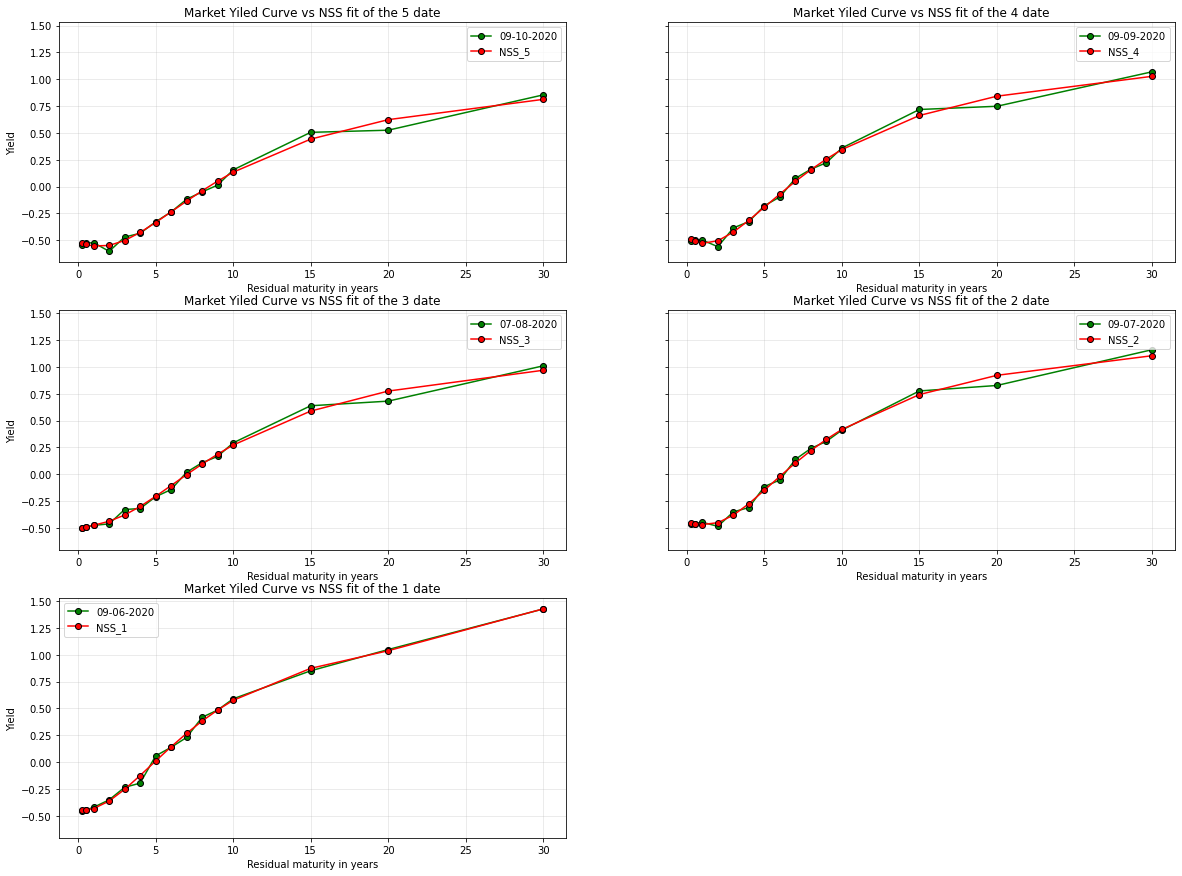

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 15), sharey=True) 

# flattening
ax = ax.flatten()

# Removing the last empty plot.
ax[-1].set_axis_off()

# ploting each plots this is done looping over the dataframe MarketData. 
for idx, col in enumerate(MarketData.iloc[:,0:5]):
    MarketData.set_index(MarketData.index.map(YearFraction))[[col, f'NSS_{Params.shape[1] - idx}']].plot(ax=ax[idx], 
                                    marker='o', color=['green', 'red'], mec='black',                    
                                    title=f'Market Yiled Curve vs NSS fit of the {Params.shape[1] - idx} date') 
    ax[idx].grid(alpha=0.3)
    ax[idx].set_xlabel('Residual maturity in years')
    ax[idx].set_ylabel('Yield')
    ax[idx].legend()
        
plt.show()

__g) Make a function that will give the daycount fraction between two dates for either convention Act/360 or Act/365 using date strings as inputs. Example dayCount('15-06-2020','15-12-2021','Act/360')__

In [16]:
# The function dayCount returns the daycount fraction between two dates for either the convention 
# Act/360 or Act/365.

def DayCount(sdate, edate, conv):
    sdate = datetime.strptime(sdate, '%d-%m-%Y')
    edate = datetime.strptime(edate, '%d-%m-%Y')
    if conv == 'Act/360':
        return (edate - sdate).days/ 360.0
    if conv == 'Act/365':
        return (edate - sdate).days/ 365.0
    else:
        print("Enter daycount convention please")
    
np.round(DayCount('15-06-2020', '15-12-2021', 'Act/360'),4)

1.5222

In [17]:
# Verifying the results.

datetime.strptime('15-06-2020', '%d-%m-%Y') + timedelta(days = 360*DayCount('15-06-2020', '15-12-2021', 'Act/360'))

datetime.datetime(2021, 12, 15, 0, 0)

In [18]:
datetime.strptime('15-06-2020', '%d-%m-%Y') + timedelta(days = 365*DayCount('15-06-2020', '15-12-2021', 'Act/365'))

datetime.datetime(2021, 12, 15, 0, 0)

__h) Make a function that not only returns the present value of a futur investment for a given rate but also prints 
a custom string. Use it to determine the present value of a payment of EUR 2,430.04 in 5 years at the rate of 5% (Annual compounded rate) and print whatever string you want.
<br> Example: pv(amount, rate, maturity, text)__

In [19]:
# The function Pv returns the present value of a futur investment for a given rate, and also prints a custom string.

def Pv(amount, rate, maturity, text):
    print(text)
    return amount/(1+rate)**maturity

In [20]:
# The present value of a future investement of the amount 2,430.04 in 5 years at the rate of 5%. 

np.round(Pv(2430.04, 0.05, 5, 'The present value is the following:'), 4)

The present value is the following:


1903.9999